**Import essential libraries for model building, image loading, visualization and evaluation**



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr

**Uplod and Extract Dataset**

In [4]:
import zipfile

zip_path = "/content/archive (1).zip"  # use the uploaded file name
extract_path = "/content/TrashType_Image_Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

dataset_dir = extract_path

In [5]:
# Set dataset directory and important parameters for loading images.
dataset_dir = "/content/TrashType_Image_Dataset/TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42


In [6]:
import os
print(os.listdir("/content/TrashType_Image_Dataset"))

['TrashType_Image_Dataset']


In [7]:
# Load 80% of the images as the training dataset from the folder.
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [8]:
# Load the remaining 20% of images as the validation dataset.
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [9]:
#Get the number of batches
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)  # Split the validation dataset into test and validation sets (50/50).
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE) # Improve test dataset performance using caching and prefetching.


In [10]:
# Print the class labels (folder names) and total number of classes.
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


Visualize Sample images with Class Names

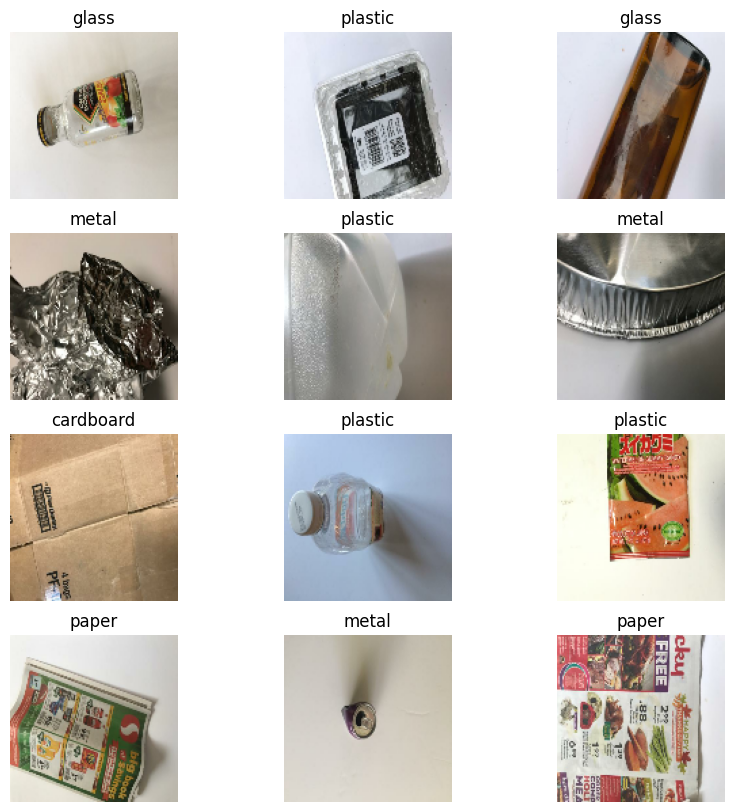

In [11]:
# Display 12 sample images from the training dataset with their labels.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")


In [12]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1  # Increment total count of labels processed

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)
        return counts  # Return percentage distribution per class

In [13]:
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.ylim(0, 100)  # Set y-axis limits (since it's percentage)
    plt.tight_layout()  # Adjust layout to avoid label cutoff
    plt.show()

In [14]:
# Get class names from training dataset
class_names = train_ds.class_names

# Calculate class distribution percentages for each dataset
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)

# Compute the average distribution from train and validation sets
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

# Print distributions
print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 399, 'metal': 322, 'paper': 471, 'plastic': 393, 'trash': 103}
{'cardboard': 13.66, 'glass': 102, 'metal': 88, 'paper': 123, 'plastic': 89, 'trash': 34}
{'cardboard': 14.06, 'glass': 45, 'metal': 43, 'paper': 64, 'plastic': 49, 'trash': 19}
{'cardboard': 15.09, 'glass': 250.5, 'metal': 205.0, 'paper': 297.0, 'plastic': 241.0, 'trash': 68.5}


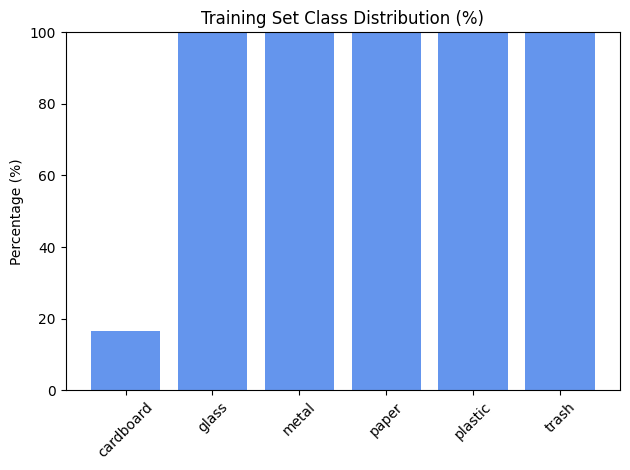

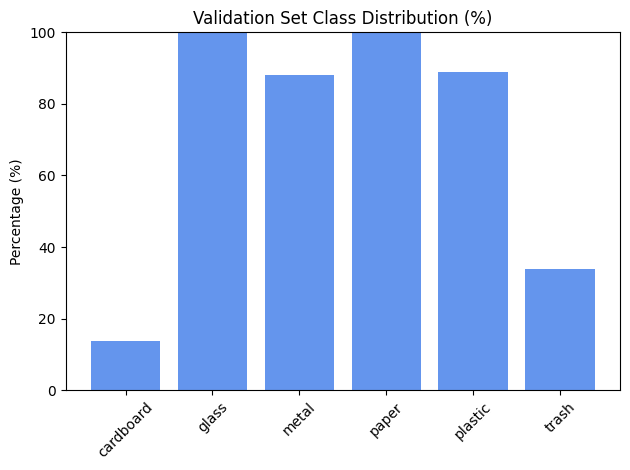

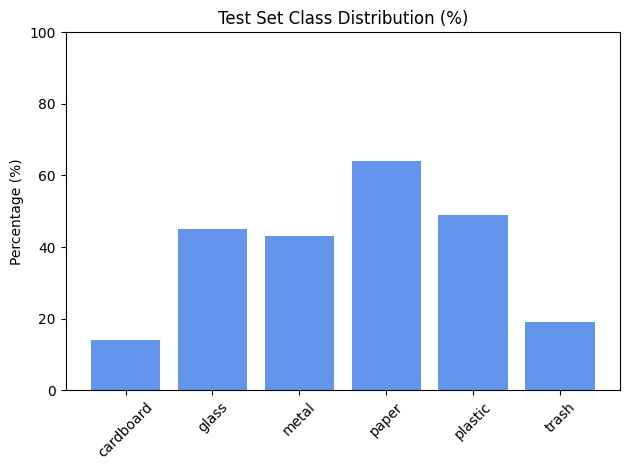

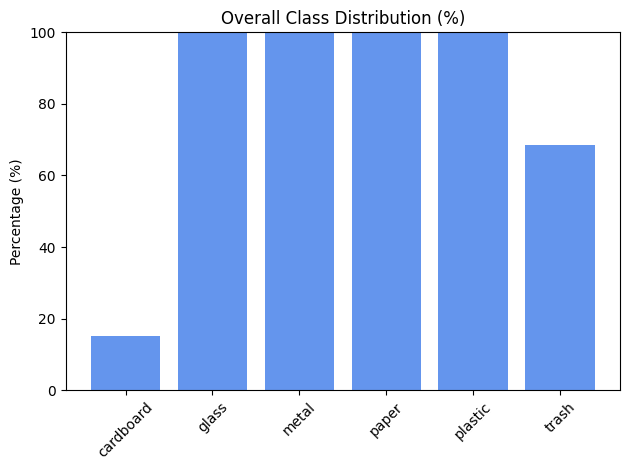

In [15]:
# Plot class distribution for each dataset using bar charts
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

**Compute Class Weights to Handle Imbalanced Classes**

In [16]:
#Initialize a dictionary to store raw class counts
class_counts = {i: 0 for i in range(len(class_names))}

# List to store all class labels in the training set
all_labels = []

# Count the number of samples per class in the training datase
for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)


#Compute class weights using sklearn's compute_class_weight
# This balances the loss function during training
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Convert the weights array into a dictionary {class_index: weight}
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [17]:
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}


**Data Preprocessing / Preparation**

Data Augmentation Pipeline to Improve Model Generalization



In [18]:
## Create a data augmentation pipeline using Keras Sequential API
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),  # Randomly flip images horizontally
    layers.RandomRotation(0.1),  # Randomly rotate images by ±10%
    layers.RandomZoom(0.1),  # Randomly zoom images by up to 10%
    layers.RandomContrast(0.1),  # Randomly zoom images by up to 10%
])

Load Pretrained EfficientNetV2B2 and Fine-Tune Select Layers


In [19]:
# Load the EfficientNetV2B2 model without the top classification layer
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')

# Set the entire model as trainable (required before selective freezing)
base_model.trainable = True

# Freeze the first 80 layers (to retain learned low-level features)
for layer in base_model.layers[:80]:
    layer.trainable = False

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
# Model Definition: Sequential Model using Transfer Learning with EfficientNetV2B2
# This model performs image classification using a pre-trained EfficientNetV2B2
# backbone with additional layers for custom classification.
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])

In [21]:
#compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**EarlyStopping callback**

In [22]:
# This callback stops training when the validation loss doesn't improve
# for 3 consecutive epochs (patience=3), helping to prevent overfitting.
# It also restores the model weights from the epoch with  best validation loss.

early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',     # Monitors the validation loss
    patience=3,             # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restores weights from the epoch with the best validation loss
)

** Train the model using .fit() with appropriate epochs, batch_size, and callbacks like EarlyStopping**

In [ ]:
epochs = 15

history = model.fit(
    train_ds,         # Training dataset
    validation_data=val_ds, # Validation dataset
    epochs=epochs,           # Total number of epochs
    class_weight=class_weights,  # Handle class imbalance
    batch_size=32,      # Mini-batch size
    callbacks=[early]  # Early stopping to avoid overfitting
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.3020 - loss: 1.7000 - val_accuracy: 0.6337 - val_loss: 1.1651
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.6674 - loss: 1.0965 - val_accuracy: 0.7743 - val_loss: 0.7982
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.7788 - loss: 0.7586 - val_accuracy: 0.8554 - val_loss: 0.5612
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8424 - loss: 0.5320 - val_accuracy: 0.8594 - val_loss: 0.4567
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.8725 - loss: 0.4155 - val_accuracy: 0.8812 - val_loss: 0.3837
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.8961 - loss: 0.3155 - val_accuracy: 0.8931 - val_loss: 0.3381
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.9387 - loss: 0.2191 - val_accuracy: 0.8911 - val_loss: 0.3303
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9438 - loss: 0.1940 - val_accuracy: 0.8990 - v